<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-датасета-и-его-предобработка" data-toc-modified-id="Загрузка-датасета-и-его-предобработка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка датасета и его предобработка</a></span></li><li><span><a href="#Графическая-визуализация-датасете" data-toc-modified-id="Графическая-визуализация-датасете-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Графическая визуализация датасете</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-модели-на-основе-алгоритма-RandomForestRegressor" data-toc-modified-id="Обучение-модели-на-основе-алгоритма-RandomForestRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение модели на основе алгоритма RandomForestRegressor</a></span></li><li><span><a href="#Обучение-модели-на-основе-алгоритма-CatBoostRegressor" data-toc-modified-id="Обучение-модели-на-основе-алгоритма-CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение модели на основе алгоритма CatBoostRegressor</a></span></li><li><span><a href="#Обучение-модели-на-основе-алгоритма-LGBMRegressor" data-toc-modified-id="Обучение-модели-на-основе-алгоритма-LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение модели на основе алгоритма LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7848 sha256=fe257fca37d51880fe8898b9c9d7608cd1a8d75a98720a4fd2387ff0ba4322e3
  Stored in directory: /home/jovyan/.cache/pip/wheels/c6/b2/69/0691b3d4de7c8d0c604cd7de94f4b2d4478a04ce3b6e4bab15
Successfully built ml-metrics
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ml_metrics
from ml_metrics import rmse

In [3]:
import pandas as pd
import seaborn as sns 


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error,mean_squared_error
from catboost import CatBoostRegressor, Pool

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV 

### Загрузка датасета и его предобработка

 - Загружаем данные;  
 - Столбец с датой/временем приводим к формату datetime64 (это позволит работать с конкретными данными из которых состоит столбец );  
 - Установим индекс таблицы равным столбцу Datetime;  
 
 

In [4]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df_=df
display (df.head(15),df.shape)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


(26496, 1)

### Графическая визуализация датасете

Визуализируем представленный набор данных, посмотрим выбросы, как респределены заказы.

In [5]:
def visio_plot():
    plt.figure(figsize=(8, 4))
    
    sns.boxplot(data=df)
    plt.title('Распределение заказов такси на "ящике с усами"')
    plt.ylabel('Кол-во заказов такси \n (ИНТЕРВАЛ 10 МИНУТ)')
    plt.show()
   
    sns.histplot(data=df,  kde=True)
    plt.title('Гистограмма распределение заказов такси ')
    plt.xlabel('Число заказов такси\n (ИНТЕРВАЛ 10 МИНУТ)')
    plt.ylabel('Частота')
    plt.show()
    descr = df['num_orders'].describe()
    print (df.describe())

    var = descr['std']/descr['mean']
    if var > 0.6:
        print ('\nКоэффициент вариации {:.2f}'.format(var),'ряд не однороден')
    else:
        print ('\nКоэффициент вариации {:.2f}'.format(var),'ряд однороден')
                        

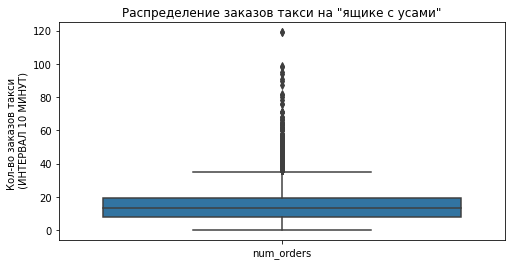

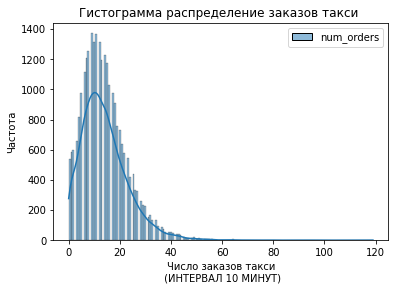

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

Коэффициент вариации 0.65 ряд не однороден


In [6]:
visio_plot()

Графики наглядно продемонстрировали наличие выбросов в кол-ве заказов такси, могу предположить, что в базе данных зафиксированы не действительные поездки, а например предзаказ или просто обращение клиента. Т.к. при среднем кол-ве вызовов 15-20 вызовов, видим кол-во заказов свыше 100 заказов. Вариант увеличения пропускной способности самолетов аэропортом в 4-5 раз не рассматриваем, как и уход всех конкурентов с данного направления. В конце концов, чтобы обслужить свыше 100 заказов (за 10 минут!!!)  нужно иметь соответвующий парк машин, который по сути будет простаивать бОльшую часть времения, когда кол-во заказов 15-20.
Резюмируя, все выбросы, что свыше 80 заказов, предлагаю удалить. 


In [7]:
df = df[(df['num_orders']<81)]
df.shape

(26485, 1)

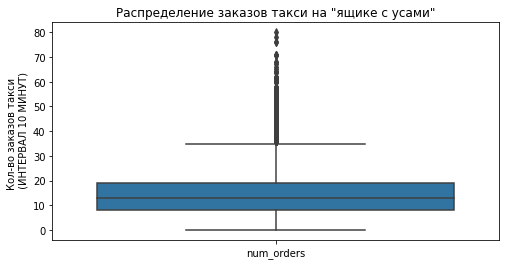

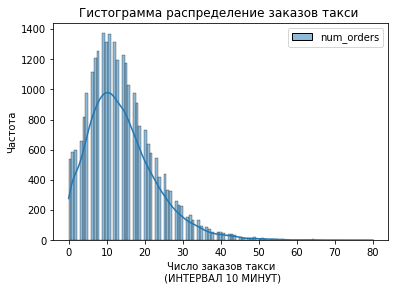

         num_orders
count  26485.000000
mean      14.036473
std        9.057538
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max       80.000000

Коэффициент вариации 0.65 ряд не однороден


In [8]:
visio_plot()

Данные предобработаны, выбросы удалены, двигаемся дальше.

<div class="alert alert-info"> Ок, принято, постараюсь применить в след. проектах </div>

## Анализ

Чтобы лучше понимать временной ряд (кол-во заказов во времени), разберём ряд на тренды и сезонность.  
Проведем ресемплирование, изменим интервал временного ряда, заданим новый интервал 1 час. 

In [9]:
df = df.resample('1H').sum()

In [10]:
decomposed = seasonal_decompose(df) #Проведем декомпозицию, выделим тренд, сезонность (если они есть)            

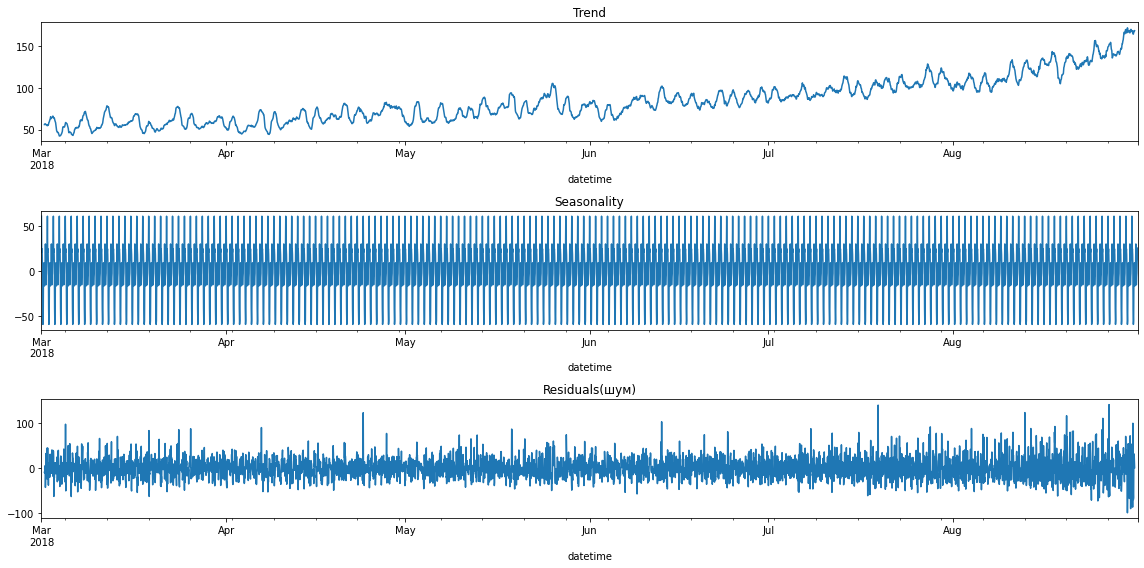

In [11]:
plt.figure(figsize=(16, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals(шум)')
plt.tight_layout()


Укрупним интервал до 1 месяца (для наглядности)

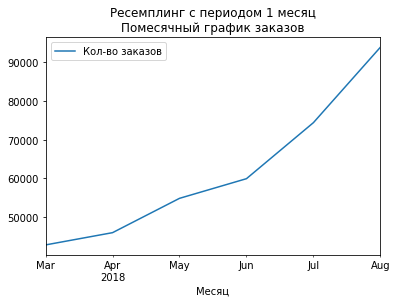

In [12]:
df.resample('1M').sum().plot()
plt.title('Ресемплинг с периодом 1 месяц\nПомесячный график заказов')
plt.legend(['Кол-во заказов'])
plt.xlabel('Месяц')
plt.show()

С ресемплингом в 1 мес., наблюдается очевидный восходящий тренд в кол-ве заказов, наиболее он выражен в летние месяцы.

Если с трендом более менее понятно то с сезонностью, такого понимания нет.  
Масштабируем "картинку", посмотрим на недельном интервале...

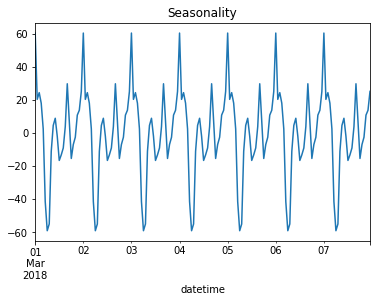

In [13]:
decomposed = decomposed.seasonal['2018-03-01':'2018-03-07']
decomposed.plot()
plt.title('Seasonality');

Здесь сезонность уже более наглядна. Видим период сезонности - 1 сутки

Исходя их формы графика, а именно:  
- наличие тренда;  
- наличие сезонности
можно заключить, что временной ряд - НЕстационарный, а это значит, что значения данного ряда не очень хорошо прогнозируются.  
Чуть ниже, попробуем математически доказать стационарность/нестационарность данного ряда.

Применим критерий Дики-Фуллера, данный критерий реализован в функции adfuller(), которая проводит тест на стациорность ряда.

In [14]:
test = sm.tsa.adfuller(df)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['1%']: #  (здесь определен уровень статистической значимости как 1 %
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

adf:  -2.962571029157015
p-value:  0.03854073676013307
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Ряд не стационарен


Отлично, нестационарность ряда доказана математически.  
Теперь приведем ряд к стационарности. 
Для создания стационарного ряда, решил воспользоваться функцией diff() - вычисляет разность исходного ряда с рядом с заданным смещением периода. 

In [15]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [16]:
dfdiff = df.diff(periods=1).dropna()

In [17]:
dfdiff

,num_orders
datetime,
2018-03-01 01:00:00,-39.0
2018-03-01 02:00:00,-14.0
2018-03-01 03:00:00,-5.0
2018-03-01 04:00:00,-23.0
2018-03-01 05:00:00,-37.0
...,...
2018-08-31 19:00:00,-71.0
2018-08-31 20:00:00,18.0
2018-08-31 21:00:00,5.0


Проверим получившийся ряд на стационарность

In [18]:
test = sm.tsa.adfuller(dfdiff)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['1%']: #  (здесь определен уровень статистической значимости как 1 %
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

adf:  -15.51609884054168
p-value:  2.3152703918177176e-28
Critical values:  {'1%': -3.431842843698785, '5%': -2.8621996550511697, '10%': -2.56712113869159}
Ряд стационарен


А вот теперь ряд стал  стационарным, а значит хорошо прогнозируется.

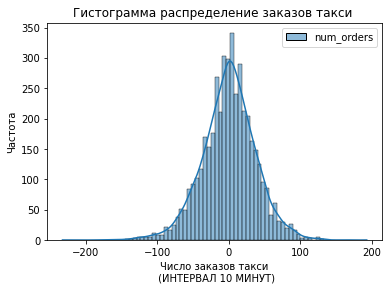

In [19]:
sns.histplot(data=dfdiff,  kde=True)
plt.title('Гистограмма распределение заказов такси ')
plt.xlabel('Число заказов такси\n (ИНТЕРВАЛ 10 МИНУТ)')
plt.ylabel('Частота')
plt.show()

Но вернемся немного назад(где ряд у нас еще нестационарен) и посмотрим на распределение заказов в течение суток.
Как говорилось ранее , наблюдается выраженная суточная "сезонность", есть часы наибольшего всплеска заказов и часы "тишины", посмотрим "поближе".  
(Чтобы во временном ряду снизить колебания, добавим скользящее среднее. )

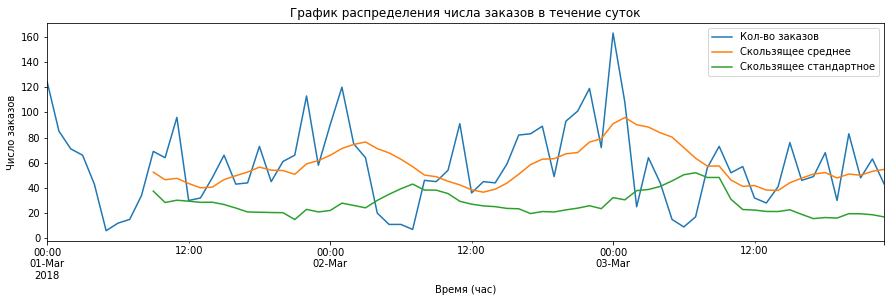

In [20]:
df_tmp = df['2018-03-01':'2018-03-03'].resample('1H').sum()
df_tmp['mean'] = df_tmp['num_orders'].rolling(10).mean()
df_tmp['std'] = df_tmp['num_orders'].rolling(10).std()
df_tmp.plot(figsize=(15,4))
plt.title('График распределения числа заказов в течение суток')
plt.xlabel('Время (час)')
plt.ylabel('Число заказов')
plt.legend(['Кол-во заказов', 'Скользящее среднее', 'Скользящее стандартное']);


Как и ожидалось, наибольшее число заказов приходиться на вечернее-ночное время (с 18 до 24 часов).



Ниже cоздадим функцию, которая создает признаки (из данных содержащихся в индексе), а так же создает признаки:  
- "Отстающие значения" (lag features, Предыдущие значения временного ряда подскажут, будет ли функция расти или уменьшаться);  
- Скользящее среднее (сглаживание временного ряда)

In [21]:
def make_features(df, max_lag, rolling_mean_size):
#    df['month'] = df.index.month
    #df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


In [22]:
make_features(dfdiff, 2, 24)
df = dfdiff.dropna()

Итак, данные загружены, предобработаны, очищены. Созданы фьючи. Преходим к обучению.

## Обучение

Разбиваем входные на 3 выборки: тестовую (10%), обучающую и валидационную.

In [23]:
features_train, features_temp, target_train, target_temp = train_test_split(df.drop(['num_orders'], axis=1), 
                                                                                    df['num_orders'],
                                                                                    test_size=0.20,
                                                                                    random_state=12345,shuffle=False)

features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp,
                                                                            test_size=0.50,
                                                                            random_state=12345,shuffle=False)

Смотрим как прошло разбиение (по условию задачи, тестовая выборка должна состоять из 10%  набора датасета)

In [24]:
print (df.shape, features_train.shape, features_valid.shape,features_test.shape )

(4391, 6) (3512, 5) (439, 5) (440, 5)


Оформим функцию по расчету метрики RMSE

In [25]:
def RMSE(target,predict):
    MSE = mean_squared_error(target, predict)
    return MSE ** 0.5

### Обучение модели на основе алгоритма RandomForestRegressor

In [26]:
%%time
model_rf = RandomForestRegressor(random_state=12345)
params_rf = {'max_depth':[5,10,15,20], 'n_estimators':[10,50,100]}
grid_rf = GridSearchCV(estimator=model_rf, param_grid = params_rf, cv = 2, n_jobs=-1)
grid_rf.fit(features_train, target_train) 
grid_rf.best_estimator_

CPU times: user 5.55 s, sys: 1.58 ms, total: 5.55 s
Wall time: 5.76 s


RandomForestRegressor(max_depth=10, random_state=12345)

In [27]:
predict_train = grid_rf.predict(features_train)
predict_valid = grid_rf.predict(features_valid)
predict_test = grid_rf.predict(features_test)
RMSE_RF_train = rmse(target_train, predict_train)
RMSE_RF_valid = rmse(target_valid, predict_valid)
RMSE_RF_test = rmse(target_test, predict_test)

print ('\nАлгоритм RandomForestRegressor, размер метрики RMSE на:')
print ('\nОбучающей выборке:',RMSE_RF_train)
print ('Валидационной выборке:',RMSE_RF_valid)
print ('Тесовой выборке:',RMSE_RF_test)


Алгоритм RandomForestRegressor, размер метрики RMSE на:

Обучающей выборке: 17.37308387592393
Валидационной выборке: 33.341631389288196
Тесовой выборке: 42.76857640123738


### Обучение модели на основе алгоритма CatBoostRegressor

In [28]:
%%time
model_cb = CatBoostRegressor(loss_function='RMSE',random_state = 12345)
params = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
grid_cb = model_cb.grid_search(params, Pool(features_train,target_train),cv=3)

0:	learn: 33.6363218	test: 33.6959478	best: 33.6959478 (0)	total: 49.1ms	remaining: 49.1s
1:	learn: 32.9600010	test: 33.0627223	best: 33.0627223 (1)	total: 50.2ms	remaining: 25s
2:	learn: 32.1626912	test: 32.3882400	best: 32.3882400 (2)	total: 51.1ms	remaining: 17s
3:	learn: 31.6996984	test: 31.9157075	best: 31.9157075 (3)	total: 51.9ms	remaining: 12.9s
4:	learn: 31.3097590	test: 31.5552218	best: 31.5552218 (4)	total: 52.8ms	remaining: 10.5s
5:	learn: 30.8880281	test: 31.1455646	best: 31.1455646 (5)	total: 53.5ms	remaining: 8.87s
6:	learn: 30.5066588	test: 30.7718419	best: 30.7718419 (6)	total: 54.3ms	remaining: 7.7s
7:	learn: 30.1393343	test: 30.4338889	best: 30.4338889 (7)	total: 55.6ms	remaining: 6.89s
8:	learn: 29.8910864	test: 30.1668863	best: 30.1668863 (8)	total: 56.8ms	remaining: 6.25s
9:	learn: 29.5473648	test: 29.9024792	best: 29.9024792 (9)	total: 57.8ms	remaining: 5.72s
10:	learn: 29.2091203	test: 29.5846917	best: 29.5846917 (10)	total: 58.6ms	remaining: 5.27s
11:	learn: 28

In [29]:
%%time
model_cb = CatBoostRegressor(depth=grid_cb['params']['depth'], 
                              learning_rate=grid_cb['params']['learning_rate'],
                              loss_function='RMSE',verbose=100)
model_cb = model_cb.fit(Pool(features_train,target_train))

0:	learn: 33.7393370	total: 1.04ms	remaining: 1.04s
100:	learn: 22.5021577	total: 80.9ms	remaining: 720ms
200:	learn: 20.7763293	total: 158ms	remaining: 626ms
300:	learn: 19.6119734	total: 241ms	remaining: 559ms
400:	learn: 18.7868811	total: 323ms	remaining: 482ms
500:	learn: 18.0574422	total: 400ms	remaining: 398ms
600:	learn: 17.4290111	total: 482ms	remaining: 320ms
700:	learn: 16.9461594	total: 565ms	remaining: 241ms
800:	learn: 16.4431285	total: 645ms	remaining: 160ms
900:	learn: 16.0026553	total: 723ms	remaining: 79.4ms
999:	learn: 15.5492465	total: 818ms	remaining: 0us
CPU times: user 873 ms, sys: 72.6 ms, total: 945 ms
Wall time: 1.47 s


In [30]:
predict_train = model_cb.predict(features_train)
predict_valid = model_cb.predict(features_valid)
predict_test = model_cb.predict(features_test)

RMSE_CB_train = RMSE(target_train, predict_train)
RMSE_CB_valid = RMSE(target_valid, predict_valid)
RMSE_CB_test = RMSE(target_test, predict_test)

print ('\nАлгоритм CatBoostRegressor, размер метрики RMSE на:')
print ('\nОбучающей выборке:',RMSE_CB_train)
print ('Валидационной выборке:',RMSE_CB_valid)
print ('Тесовой выборке:',RMSE_CB_test)


Алгоритм CatBoostRegressor, размер метрики RMSE на:

Обучающей выборке: 15.549246491098035
Валидационной выборке: 31.695628336350783
Тесовой выборке: 42.321669906648545


### Обучение модели на основе алгоритма LGBMRegressor

In [31]:
%%time
model = lgb.LGBMRegressor(objective="regression", random_state=12345,verbose=-1, num_leaves=31,n_estimators = 5)

"""
model = lgb.LGBMRegressor(
    task = 'predict',
    application = 'regression',
    objective = 'root_mean_squared_error',
    boosting_type="gbdt",
    num_iterations = 25,
    learning_rate = 0.05,
    num_leaves=15,
    tree_learner='feature',
    max_depth =10,
    min_data_in_leaf=7,
    bagging_fraction = 1,
    bagging_freq = 100,
    reg_sqrt='True',
    metric ='rmse',
    feature_fraction = 0.6,
    random_state=12345)
"""

params = {
    'learning_rate': [0.1,0.3],  
    'max_depth': [15]
     #,    'feature_fraction': [0.1,0.5]#,1.0]
}

grid = GridSearchCV(estimator = model, param_grid = params, n_jobs=-1)
grid.fit(features_train, target_train)

predict_train_lgbm = grid.predict(features_train)
predict_valid_lgbm = grid.predict(features_valid)
predict_test_lgbm = grid.predict(features_test)

RMSE_LGBM_train = RMSE(target_train, predict_train_lgbm)
RMSE_LGBM_valid = RMSE(target_valid, predict_valid_lgbm)
RMSE_LGBM_test = RMSE(target_test, predict_test_lgbm)

print(f'\nBest parameters found by grid search are: {grid.best_params_}')
print(f'Best score found by grid search are: {grid.best_score_}')


print ('\nАлгоритм LGBMRegressor, размер метрики RMSE на:')
print ('\nОбучающей выборке:',RMSE_LGBM_train)
print ('Валидационной выборке:',RMSE_LGBM_valid)
print ('Тесовой выборке:',RMSE_LGBM_test)


Best parameters found by grid search are: {'learning_rate': 0.3, 'max_depth': 15}
Best score found by grid search are: 0.39967510469334344

Алгоритм LGBMRegressor, размер метрики RMSE на:

Обучающей выборке: 23.885411570239377
Валидационной выборке: 35.21460687943498
Тесовой выборке: 44.87695971611695
CPU times: user 2min 50s, sys: 671 ms, total: 2min 51s
Wall time: 2min 52s


In [32]:
def lgbm (features_train, target_train,features_valid, target_valid, params):

    model = lgb.LGBMRegressor(objective="regression",random_state=12345, **params)
    
    model.fit(features_train, target_train)
    

    predict = model.predict(features_train)
    predict_valid = model.predict(features_valid)
    predict_test = model.predict(features_test)

    RMSE_LGBM_test = RMSE(target_test, predict_test)
    
    print ('\nАлгоритм LGBMRegressor, размер метрики RMSE на:')
    print ('\nОбучающей выборке:',RMSE(target_train, predict))
    print ('Валидационной выборке:',RMSE(target_valid, predict_valid))
    print ('Тесовой выборке:', RMSE_LGBM_test)
    
    lgb.plot_importance(model, figsize=(5,4),max_num_features=5);
    return RMSE_LGBM_test


Алгоритм LGBMRegressor, размер метрики RMSE на:

Обучающей выборке: 13.005374181134268
Валидационной выборке: 32.31675460630021
Тесовой выборке: 42.35662551418446
CPU times: user 5min 33s, sys: 1.44 s, total: 5min 34s
Wall time: 5min 37s


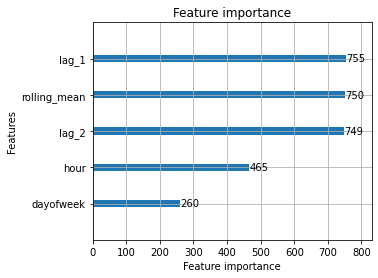

In [33]:
%%time
RMSE_LGBM_test=lgbm(features_train, target_train, features_valid, target_valid, grid.best_params_)

## Тестирование

Поскольку в процессе построения модели на основе различных алгоритмов я сразу вычислял размер метрики на тестовой выборке, то у нас уже есть размер метрики RMSE для различных алгоритмов, и наименьшее значение метрики получено на основе алгоритма CatBoost.  
Ниже, я все значения свел в таблицу. 

In [34]:
total_report = pd.DataFrame(columns = ['RandomForest','CatBoost','LightGBM'],
                      index = ['RMSE(train)','RMSE(valid)','RMSE(test)'])


total_report.iloc[0] = [RMSE_RF_train,RMSE_CB_train,RMSE_LGBM_train]
total_report.iloc[1] = [RMSE_RF_valid,RMSE_CB_valid,RMSE_LGBM_valid]
total_report.iloc[2] = [RMSE_RF_test,RMSE_CB_test,RMSE_LGBM_test]

In [35]:
total_report

,RandomForest,CatBoost,LightGBM
RMSE(train),17.373084,15.549246,23.885412
RMSE(valid),33.341631,31.695628,35.214607
RMSE(test),42.768576,42.32167,42.356626


**На самом деле алгоритм LightGBM демонстрирует схожие показатели при n_estimators = 50, но у меня расчет с перебором параметров занимает непозволительно много времени, поэтому остановился на CatBoost**

Что касается разности значений метрики RMSE для различных алгоритмов, кажется, что разница в 2-3 единицы небольшая, но на самом деле, если сравнить реальный график заказов и прогнозируемый, то разница будет очевидна.  
Ниже я вывел оригинал и прогноз на единый график, и видим, что прогноз на основе алгоритма LGBM (при значениях 46-47 ед.) откровенно не  отрабатывает пиковые нагрузки по заказам такси(боюсь представить, какой бы был прогноз со значениями rmse 48 и более). В общем бороться нужно за каждую единицу метрики ... :).

In [36]:
predict_test_lgbm = grid.predict(features_test)
predict_test_cat = model_cb.predict(features_test)

In [37]:
def visio_results(prediction1,prediction2):
    visio_predict = pd.DataFrame(target_test, index=target_test.index)
    visio_predict['Прогноз на основе LGBM'] = prediction1
    visio_predict['Прогноз на основе CatBoost'] = prediction2
    visio_predict['2018-08-14':'2018-08-16'].plot(figsize=(12,6))
    print ('Алгоритм LRBM,Размер метрики RMSE на тестовой выборке:',RMSE(target_test, predict_test_lgbm))
    print ('Алгоритм CB,Размер метрики RMSE на тестовой выборке:',RMSE(target_test, predict_test_cat))

Алгоритм LRBM,Размер метрики RMSE на тестовой выборке: 44.87695971611695
Алгоритм CB,Размер метрики RMSE на тестовой выборке: 42.321669906648545


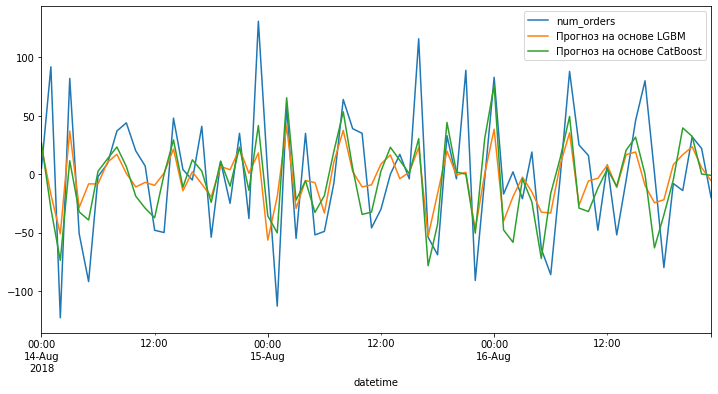

In [38]:
visio_results(predict_test_lgbm,predict_test_cat)

## Вывод

**Проведя обработку входных данных, а именно приведя входной ряд к стационарному (что обеспечило хорошее качество прогнозирования), была построена прогнозная модель заказов такси на основе трех различных алгоритмов: RandomForest, CatBoost, LightGBM.  
Наилучший показатель метрики RMSE (учитывая гиперпареметры и формирование признаков для модели) удалось достичь на основе алгоритма CatBoost, размер метрики составил 42,6 единицы.**
